In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
# 假设配置文件已经定义，并包含了一些基本设置
import config
args = config.args
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [109]:
train_csv = pd.read_csv("D:/下载的文件/archive/fashion-mnist_train.csv")
test_csv = pd.read_csv("D:/下载的文件/archive/fashion-mnist_test.csv")

In [110]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [111]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=args.batch_size)
test_loader = DataLoader(train_set, batch_size=args.batch_size)

In [112]:
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
"""          

'\ntrain_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=\n                                                transforms.Compose([transforms.ToTensor()]))\ntest_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=\n                                               transforms.Compose([transforms.ToTensor()]))  \n'

In [113]:
"""
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
"""    

'\ntrain_loader = torch.utils.data.DataLoader(train_set, \n                                           batch_size=100)\ntest_loader = torch.utils.data.DataLoader(test_set,\n                                          batch_size=100)\n'

In [114]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [115]:
a = next(iter(train_loader))
a[0].size()

torch.Size([4, 1, 28, 28])

In [116]:
len(train_set)

60000

2


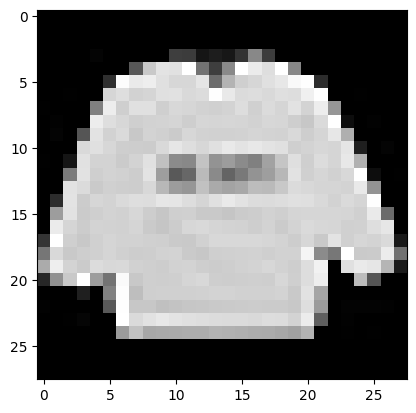

In [117]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [118]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([4, 1, 28, 28]) torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, 

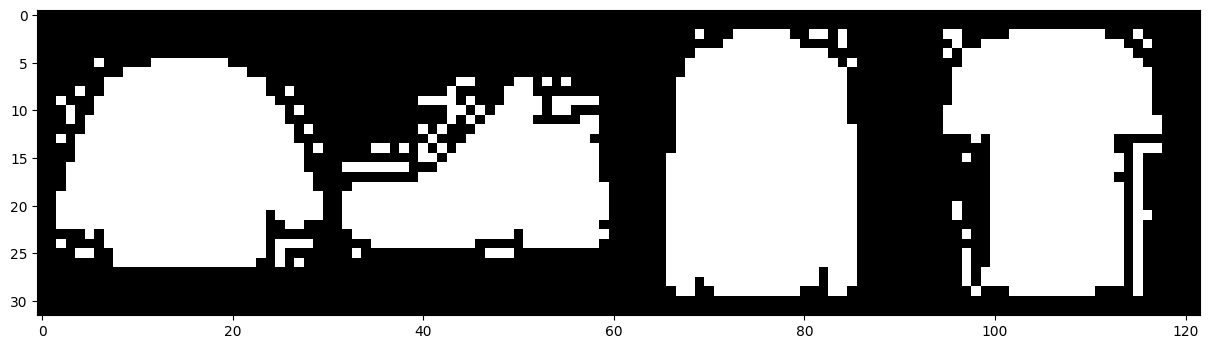

In [119]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [120]:

class FashionCNN(nn.Module):
    
    def __init__(self, input_size=784, hidden_layer_size=256, num_classes=10):
        super(FashionCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 784)  # 展平图像张量为向量
        x = F.relu(self.fc1(x))  # 第一层加ReLU激活
        x = self.fc2(x)  # 输出层
        return x

In [121]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = args.lr
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [122]:
num_epochs = args.epochs
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(4, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(4, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
            

Iteration: 500, Loss: 2.2859740257263184, Accuracy: 13.408333778381348%
Iteration: 1000, Loss: 2.3364391326904297, Accuracy: 12.305000305175781%
Iteration: 1500, Loss: 2.2858266830444336, Accuracy: 10.998332977294922%
Iteration: 2000, Loss: 2.297390937805176, Accuracy: 10.029999732971191%
Iteration: 2500, Loss: 2.247574806213379, Accuracy: 10.029999732971191%
Iteration: 3000, Loss: 2.294484853744507, Accuracy: 10.02833366394043%
Iteration: 3500, Loss: 2.3371334075927734, Accuracy: 10.069999694824219%
Iteration: 4000, Loss: 2.3694305419921875, Accuracy: 10.02833366394043%
Iteration: 4500, Loss: 2.3362717628479004, Accuracy: 10.03499984741211%


KeyboardInterrupt: 

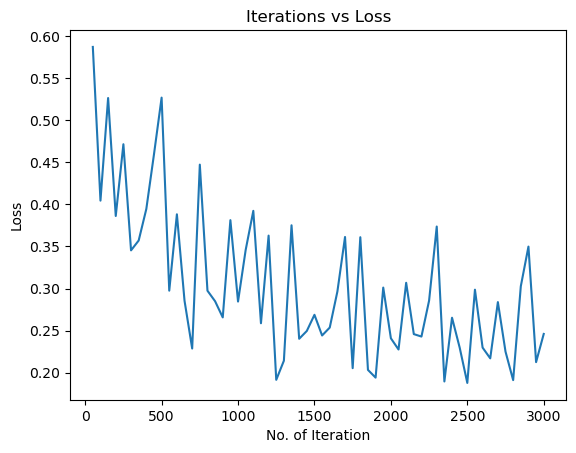

In [ ]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

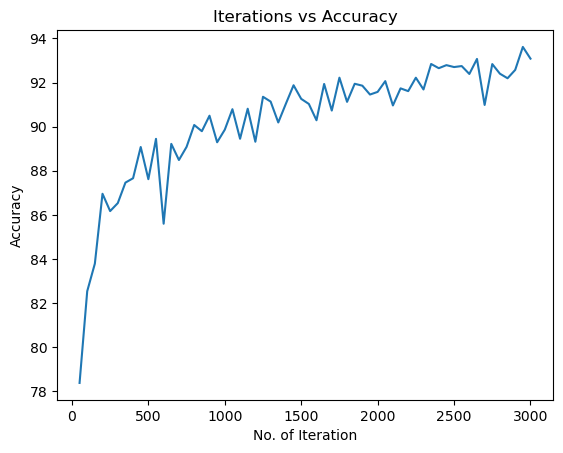

In [ ]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 79.95%
Accuracy of Trouser: 99.18%
Accuracy of Pullover: 90.13%
Accuracy of Dress: 93.37%
Accuracy of Coat: 89.87%
Accuracy of Sandal: 97.82%
Accuracy of Shirt: 86.88%
Accuracy of Sneaker: 95.47%
Accuracy of Bag: 99.78%
Accuracy of Ankle Boot: 99.13%


In [ ]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [ ]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.85      0.85      0.85    360000
           1       0.98      0.98      0.98    360000
           2       0.84      0.86      0.85    360000
           3       0.89      0.91      0.90    360000
           4       0.84      0.84      0.84    360000
           5       0.97      0.98      0.97    360000
           6       0.75      0.71      0.73    360000
           7       0.95      0.95      0.95    360000
           8       0.98      0.98      0.98    360000
           9       0.96      0.96      0.96    360000

    accuracy                           0.90   3600000
   macro avg       0.90      0.90      0.90   3600000
weighted avg       0.90      0.90      0.90   3600000




In [ ]:
torch.save(model.state_dict(), 'FashionCNN.pt')

In [ ]:
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

def predict(model, loader, device):
    """Perform predictions with the model on the provided data loader."""
    model.eval()
    predictions_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            images = Variable(images.view(100, 1, 28, 28))
            outputs = model(images)
            predictions = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions)
            labels_list.append(labels)
    return predictions_list, labels_list

def train_and_validate(model, train_loader, test_loader, device, optimizer, error, args):
    num_epochs = args.epochs
    count = 0
    
    # Accuracy lists for training and validation
    train_accuracy_history = []
    val_accuracy_history = []
    
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            train = Variable(images.view(100, 1, 28, 28))
            labels = Variable(labels)
            outputs = model(train)
            loss = error(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            predictions = torch.max(outputs, 1)[1]
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        # Calculate training accuracy
        train_accuracy = 100 * train_correct / train_total
        train_accuracy_history.append(train_accuracy)
        
        # Prediction for validation data
        val_predictions, val_labels = predict(model, test_loader, device)
        val_correct = sum((p == l).sum().item() for p, l in zip(val_predictions, val_labels))
        val_total = sum(len(l) for l in val_labels)
        val_accuracy = 100 * val_correct / val_total
        val_accuracy_history.append(val_accuracy)
        
        print(f"Epoch {epoch+1}: Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Plot accuracy history
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Uncomment the following lines to test these functions with actual parameters:
# train_and_validate(model, train_loader, test_loader, device, optimizer, error, args)

